# Student Performance Classification Project

This notebook classifies student performance into reminder categories: **low**, **medium**, and **high**.  
The target variable is created from the average of **math**, **reading**, and **writing** scores.

We compare multiple classifiers using **5-fold Stratified Cross-Validation** on the training set and evaluate the final performance on a **hold-out test set (20%)**.

**Models compared:**
- Decision Tree
- Random Forest
- SVM (RBF)
- Multinomial Logistic Regression


## 1. Libraries
We import libraries for:
- data loading and manipulation (pandas, numpy)
- preprocessing and pipelines (ColumnTransformer, OneHotEncoder, StandardScaler, Pipeline)
- model training and evaluation (CV metrics, confusion matrices, classification reports)
- visualization (matplotlib)


In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## 2. Data Loading
The dataset is loaded from an Excel file.

In [2]:
# Recommended: keep the dataset in the same folder as this notebook
DEFAULT_RELATIVE_PATH = "Students Performance Balance Dataset.xlsx"

# Your local path (fallback)
FALLBACK_LOCAL_PATH = r"C:\Users\Çiçek\Desktop\Students Performance Balance Dataset.xlsx"

EXCEL_PATH = DEFAULT_RELATIVE_PATH if os.path.exists(DEFAULT_RELATIVE_PATH) else FALLBACK_LOCAL_PATH

df = pd.read_excel(EXCEL_PATH)
print("Loaded dataset shape:", df.shape)
df.head()


Loaded dataset shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group b,bachelor's degree,standard,none,72,72,74
1,female,group c,some college,standard,completed,69,90,88
2,female,group b,master's degree,standard,none,90,95,93
3,male,group a,associate's degree,free/reduced,none,47,57,44
4,male,group c,some college,standard,none,76,78,75


## 3. Basic Cleaning and Feature Engineering
1. Convert categorical text columns to lowercase for consistency.
2. Compute `average_score` as the mean of:
   - math score
   - reading score
   - writing score
3. Define the target label `performance`:
   - **low** if average < 60  
   - **medium** if 60 ≤ average < 80  
   - **high** if average ≥ 80


In [3]:
# Convert categorical columns to lowercase
cat_cols = df.select_dtypes(include="object").columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.lower())

# Create average score
score_cols = ["math score", "reading score", "writing score"]
df["average_score"] = df[score_cols].mean(axis=1)

# Target label function
def performance_label(avg):
    if avg < 60:
        return "low"
    elif avg < 80:
        return "medium"
    else:
        return "high"

df["performance"] = df["average_score"].apply(performance_label)

# Quick check: class distribution
print("Class distribution:\n", df["performance"].value_counts())
df[["math score","reading score","writing score","average_score","performance"]].head()

Class distribution:
 performance
medium    517
low       285
high      198
Name: count, dtype: int64


,math score,reading score,writing score,average_score,performance
0,72,72,74,72.666667,medium
1,69,90,88,82.333333,high
2,90,95,93,92.666667,high
3,47,57,44,49.333333,low
4,76,78,75,76.333333,medium


## 4. Define Features (X) and Target (y)
- `y` is the target class: **performance**
- `X` contains all predictors except the target and the engineered average score.

In [4]:
y = df["performance"]
X = df.drop(columns=["performance", "average_score"])

categorical_cols = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course"
]
numeric_cols = score_cols

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 8)
y shape: (1000,)


## 5. Preprocessing Pipeline
We apply preprocessing using **ColumnTransformer**:
- Categorical features → OneHotEncoder (handle unknown categories, drop first)
- Numeric features → StandardScaler

This ensures that preprocessing is applied consistently within each model pipeline.

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ],
    remainder="drop"
)

## 6. Train/Test Split
We split the data into:
- Training set: 80%
- Test set: 20%

We use **stratification** to preserve class proportions in both splits.
A fixed random seed ensures reproducibility.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))

Train size: (800, 8) Test size: (200, 8)

Train class distribution:
 performance
medium    0.5175
low       0.2850
high      0.1975
Name: proportion, dtype: float64

Test class distribution:
 performance
medium    0.515
low       0.285
high      0.200
Name: proportion, dtype: float64


## 7. Models and Cross-Validation Setup
We compare 4 classification models using **5-Fold Stratified Cross-Validation** on the training set.

Because the dataset may contain class imbalance, we use **weighted metrics**:
- Accuracy
- Weighted Precision
- Weighted Recall
- Weighted F1-score

In [7]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
    "Logistic Regression (Multinomial)": LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=2000,
        random_state=42
    ),
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_w": "precision_weighted",
    "recall_w": "recall_weighted",
    "f1_w": "f1_weighted",
}

## 8. Training Results (5-Fold Stratified Cross-Validation)
We compute the mean and standard deviation of accuracy across folds, and the mean of weighted precision/recall/F1.

This provides a more reliable estimate of performance than a single random split.

In [8]:
training_rows = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    cv = cross_validate(pipe, X_train, y_train, cv=kf, scoring=scoring)

    training_rows.append({
        "Model": name,
        "Accuracy (Mean)": cv["test_accuracy"].mean(),
        "Accuracy (Std)": cv["test_accuracy"].std(),
        "Precision (Weighted Mean)": cv["test_precision_w"].mean(),
        "Recall (Weighted Mean)": cv["test_recall_w"].mean(),
        "F1 (Weighted Mean)": cv["test_f1_w"].mean(),
    })

training_df = pd.DataFrame(training_rows)
training_df["Accuracy (Mean ± SD)"] = training_df.apply(
    lambda r: f'{r["Accuracy (Mean)"]:.4f} ± {r["Accuracy (Std)"]:.4f}', axis=1
)

print("TRAINING RESULTS (5-Fold Stratified CV)\n")
display(training_df[[
    "Model",
    "Accuracy (Mean ± SD)",
    "Precision (Weighted Mean)",
    "Recall (Weighted Mean)",
    "F1 (Weighted Mean)"
]].sort_values(by="F1 (Weighted Mean)", ascending=False))

TRAINING RESULTS (5-Fold Stratified CV)



,Model,Accuracy (Mean ± SD),Precision (Weighted Mean),Recall (Weighted Mean),F1 (Weighted Mean)
3,Logistic Regression (Multinomial),0.9788 ± 0.0116,0.979087,0.97875,0.978662
2,SVM (RBF),0.9637 ± 0.0100,0.964601,0.96375,0.963629
1,Random Forest,0.9625 ± 0.0143,0.963628,0.96250,0.962359
0,Decision Tree,0.9488 ± 0.0073,0.949423,0.94875,0.948665


## 9. Confusion Matrix Visualization (Professional Gray–Red Theme)
We plot confusion matrices with:
- fixed label order: **low, medium, high**
- a professional gray-to-reddish colormap
- readable annotation colors based on cell intensity

In [9]:
LABELS = ["low", "medium", "high"]

def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    # Gray -> muted red colormap (professional, readable)
    cmap = LinearSegmentedColormap.from_list(
        "gray_red",
        ["#f2f2f2", "#cfcfcf", "#b05a5a", "#7a1f1f"]
    )

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap=cmap)

    ax.set_title(title, pad=12)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Annotate cells with dynamic text color for readability
    max_val = cm.max() if cm.max() != 0 else 1
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            # White text on darker cells, black on lighter
            text_color = "white" if val > (0.45 * max_val) else "black"
            ax.text(j, i, str(val), ha="center", va="center", color=text_color, fontsize=11)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

## 10. Test Set Evaluation (Hold-out)
For each model:
1. Fit on the full training set
2. Predict on the test set
3. Report:
   - Confusion Matrix (with fixed label order)
   - Classification Report
   - Weighted metrics table (Accuracy, Precision, Recall, F1)


MODEL: Decision Tree


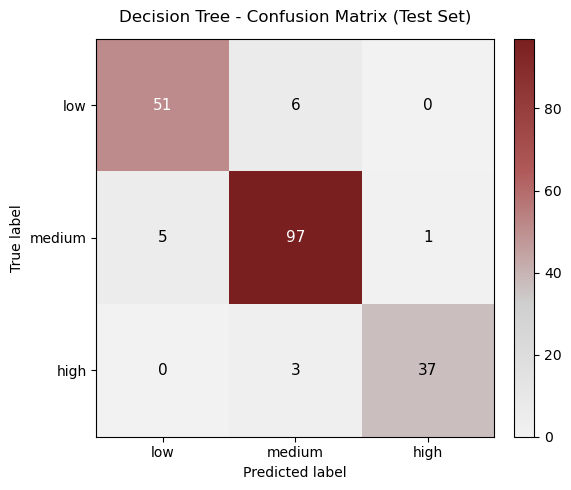


Classification Report (Test Set):
              precision    recall  f1-score   support

         low       0.91      0.89      0.90        57
      medium       0.92      0.94      0.93       103
        high       0.97      0.93      0.95        40

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.93       200
weighted avg       0.93      0.93      0.93       200


MODEL: Random Forest


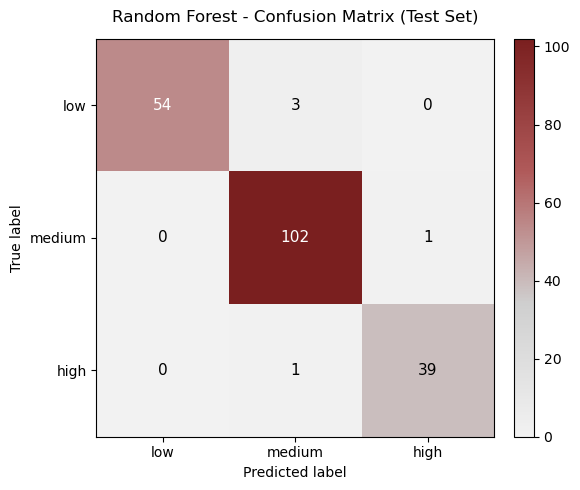


Classification Report (Test Set):
              precision    recall  f1-score   support

         low       1.00      0.95      0.97        57
      medium       0.96      0.99      0.98       103
        high       0.97      0.97      0.97        40

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200


MODEL: SVM (RBF)


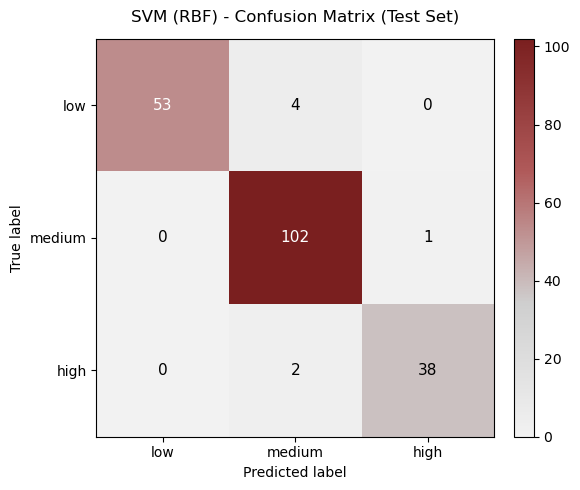


Classification Report (Test Set):
              precision    recall  f1-score   support

         low       1.00      0.93      0.96        57
      medium       0.94      0.99      0.97       103
        high       0.97      0.95      0.96        40

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200


MODEL: Logistic Regression (Multinomial)


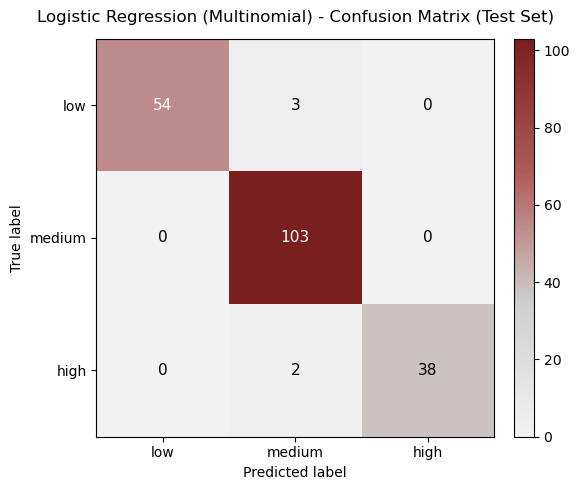


Classification Report (Test Set):
              precision    recall  f1-score   support

         low       1.00      0.95      0.97        57
      medium       0.95      1.00      0.98       103
        high       1.00      0.95      0.97        40

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



In [10]:
testing_rows = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Fixed label order confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=LABELS)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    testing_rows.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (Weighted)": prec,
        "Recall (Weighted)": rec,
        "F1 (Weighted)": f1,
    })

    print("\n" + "="*60)
    print(f"MODEL: {name}")
    print("="*60)

    plot_confusion_matrix(cm, LABELS, title=f"{name} - Confusion Matrix (Test Set)")

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, labels=LABELS, zero_division=0))

## 11. Final Test Results Table
We summarize all model performances on the hold-out test set in a single table.

In [11]:
testing_df = pd.DataFrame(testing_rows)
display(testing_df.sort_values(by="F1 (Weighted)", ascending=False))

,Model,Accuracy,Precision (Weighted),Recall (Weighted),F1 (Weighted)
1,Random Forest,0.975,0.975566,0.975,0.974977
3,Logistic Regression (Multinomial),0.975,0.976157,0.975,0.974965
2,SVM (RBF),0.965,0.966261,0.965,0.964956
0,Decision Tree,0.925,0.925564,0.925,0.925039


## 12. Export Results
We export training cross-validation results and test results to CSV files for reporting and appendix usage.

In [12]:
training_df.to_csv("stage3_training_results.csv", index=False)
testing_df.to_csv("stage3_test_results.csv", index=False)

print("Saved files:")
print("- stage3_training_results.csv")
print("- stage3_test_results.csv")

Saved files:
- stage3_training_results.csv
- stage3_test_results.csv


## 13. Conclusion
We evaluated multiple classifiers for student performance prediction using:
- stratified cross-validation for reliable training performance estimates
- a hold-out test set for final evaluation

The final decision can be made by comparing weighted F1 scores and confusion matrices, especially if class imbalance is present.
